# Inspecting Call Stacks

In this book, for many purposes, we need to look up a function's location, source code, or simply definition. The class `StackInspector` provides a number of convenience methods for this purpose.

**Prerequisites**

* This is an internal helper class.
* Understanding how frames and local variables are represented in Python helps.

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from debuggingbook.StackInspector import <identifier>
```

and then make use of the following features.


`StackInspector` is typically used as superclass, providing its functionality to subclasses. 

Here is an example of how to use `caller_function()`. The `test()` function invokes an internal method `caller()` of `StackInspectorDemo`, which in turn invokes `callee()`:

| Function | Class | |
| --- | --- | --- |
| `callee()` | `StackInspectorDemo` | |
| `caller()` | `StackInspectorDemo` | invokes $\uparrow$ |
| `test()` | (main) | invokes $\uparrow$ |
| -/- | (main) | invokes $\uparrow$ |

Using `caller_function()`, `callee()` determines the first caller outside a `StackInspector` class and prints it out – i.e., `<function test>`.

```python
>>> class StackInspectorDemo(StackInspector):
>>>     def callee(self) -> None:
>>>         func = self.caller_function()
>>>         assert func.__name__ == 'test'
>>>         print(func)
>>> 
>>>     def caller(self) -> None:
>>>         self.callee()
>>> def test() -> None:
>>>     demo = StackInspectorDemo()
>>>     demo.caller()
>>> test()
<function test at 0x1101edee0>

```
Here are all methods defined in this chapter:

![](PICS/StackInspector-synopsis-1.svg)



## Inspecting Call Stacks

`StackInspector` is a class that provides a number of utility functions to inspect a [call stack](https://en.wikipedia.org/wiki/Call_stack), notably to identify caller functions.

When tracing or instrumenting functions, a common issue is to identify the currently active functions. A typical situation is depicted below, where `my_inspector()` currently traces a function called `function_under_test()`.

| Function | Class | |
| --- | --- | --- |
| ... | `StackInspector` | |
| `caller_frame()` | `StackInspector` | invokes $\uparrow$ |
| `caller_function()` | `StackInspector` | invokes $\uparrow$ |
| `my_inspector()` | some inspector; a subclass of `StackInspector` | invokes $\uparrow$ |
| `function_under_test()` | (any) | is traced by $\uparrow$ |
| -/- | (any) | invokes $\uparrow$ |

To determine the calling function, `my_inspector()` could check the current frame and retrieve the frame of the caller. However, this caller could be some tracing function again invoking `my_inspector()`. Therefore, `StackInspector` provides a method `caller_function()` that returns the first caller outside a `StackInspector` class. This way, a subclass of `StackInspector` can define an arbitrary set of functions (and call stack); `caller_function()` will always return a function outside the `StackInspector` subclass.

In [1]:
import bookutils.setup

In [2]:
import inspect
import warnings

In [3]:
from types import FunctionType, FrameType, TracebackType

In [4]:
# ignore
from typing import cast, Dict, Any, Tuple, Callable, Optional, Type

The method `caller_frame()` walks the current call stack from the current frame towards callers (using the `f_back` attribute of the current frame) and returns the first frame that is _not_  a method or function from the current `StackInspector` class or its subclass. To determine this, the method `our_frame()` determines whether the given execution frame refers to one of the methods of `StackInspector` or one of its subclasses.

In [5]:
class StackInspector:
    """Provide functions to inspect the stack"""

    def caller_frame(self) -> FrameType:
        """Return the frame of the caller."""

        # Walk up the call tree until we leave the current class
        frame = cast(FrameType, inspect.currentframe())

        while self.our_frame(frame):
            frame = cast(FrameType, frame.f_back)

        return frame

    def our_frame(self, frame: FrameType) -> bool:
        """Return true if `frame` is in the current (inspecting) class."""
        return isinstance(frame.f_locals.get('self'), self.__class__)

When we access program state or execute functions, we do so in the  caller's environment, not ours. The `caller_globals()` method acts as replacement for `globals()`, using `caller_frame()`.

In [6]:
class StackInspector(StackInspector):
    def caller_globals(self) -> Dict[str, Any]:
        """Return the globals() environment of the caller."""
        return self.caller_frame().f_globals

    def caller_locals(self) -> Dict[str, Any]:
        """Return the locals() environment of the caller."""
        return self.caller_frame().f_locals

The method `caller_location()` returns the caller's function and its location. It does a fair bit of magic to retrieve nested functions, by looking through global and local variables until a match is found. This may be simplified in the future.

In [7]:
Location = Tuple[Callable, int]

In [8]:
class StackInspector(StackInspector):
    def caller_location(self) -> Location:
        """Return the location (func, lineno) of the caller."""
        return self.caller_function(), self.caller_frame().f_lineno

The function `search_frame()` allows searching for an item named `name`, walking up the call stack. This is handy when trying to find local functions during tracing, for whom typically only the name is provided.

In [9]:
class StackInspector(StackInspector):
    def search_frame(self, name: str, frame: Optional[FrameType] = None) -> \
        Tuple[Optional[FrameType], Optional[Callable]]:
        """
        Return a pair (`frame`, `item`) 
        in which the function `name` is defined as `item`.
        """
        if frame is None:
            frame = self.caller_frame()

        while frame:
            item = None
            if name in frame.f_globals:
                item = frame.f_globals[name]
            if name in frame.f_locals:
                item = frame.f_locals[name]
            if item and callable(item):
                return frame, item

            frame = cast(FrameType, frame.f_back)

        return None, None

    def search_func(self, name: str, frame: Optional[FrameType] = None) -> \
        Optional[Callable]:
        """Search in callers for a definition of the function `name`"""
        frame, func = self.search_frame(name, frame)
        return func

If we cannot find a function by name, we can create one, using `create_function()`.

In [10]:
class StackInspector(StackInspector):
    # Avoid generating functions more than once
    _generated_function_cache: Dict[Tuple[str, int], Callable] = {}

    def create_function(self, frame: FrameType) -> Callable:
        """Create function for given frame"""
        name = frame.f_code.co_name
        cache_key = (name, frame.f_lineno)
        if cache_key in self._generated_function_cache:
            return self._generated_function_cache[cache_key]

        try:
            # Create new function from given code
            generated_function = cast(Callable,
                                      FunctionType(frame.f_code,
                                                   globals=frame.f_globals,
                                                   name=name))
        except TypeError:
            # Unsuitable code for creating a function
            # Last resort: Return some function
            generated_function = self.unknown

        except Exception as exc:
            # Any other exception
            warnings.warn(f"Couldn't create function for {name} "
                          f" ({type(exc).__name__}: {exc})")
            generated_function = self.unknown

        self._generated_function_cache[cache_key] = generated_function
        return generated_function

The method `caller_function()` puts all of these together, simply looking up and returning the currently calling function – and creating one if it cannot be found.

In [11]:
class StackInspector(StackInspector):
    def caller_function(self) -> Callable:
        """Return the calling function"""
        frame = self.caller_frame()
        name = frame.f_code.co_name
        func = self.search_func(name)
        if func:
            return func

        if not name.startswith('<'):
            warnings.warn(f"Couldn't find {name} in caller")

        return self.create_function(frame)

    def unknown(self) -> None:  # Placeholder for unknown functions
        pass

The method `is_internal_error()` allows us to differentiate whether some exception was raised by `StackInspector` (or a subclass) – or whether it was raised by the inspected code.

In [12]:
import traceback

In [13]:
class StackInspector(StackInspector):
    def is_internal_error(self, exc_tp: Type, 
                          exc_value: BaseException, 
                          exc_traceback: TracebackType) -> bool:
        """Return True if exception was raised from `StackInspector` or a subclass."""
        if not exc_tp:
            return False

        for frame, lineno in traceback.walk_tb(exc_traceback):
            if self.our_frame(frame):
                return True

        return False

## Synopsis

`StackInspector` is typically used as superclass, providing its functionality to subclasses. 

Here is an example of how to use `caller_function()`. The `test()` function invokes an internal method `caller()` of `StackInspectorDemo`, which in turn invokes `callee()`:

| Function | Class | |
| --- | --- | --- |
| `callee()` | `StackInspectorDemo` | |
| `caller()` | `StackInspectorDemo` | invokes $\uparrow$ |
| `test()` | (main) | invokes $\uparrow$ |
| -/- | (main) | invokes $\uparrow$ |

Using `caller_function()`, `callee()` determines the first caller outside a `StackInspector` class and prints it out – i.e., `<function test>`.

In [14]:
class StackInspectorDemo(StackInspector):
    def callee(self) -> None:
        func = self.caller_function()
        assert func.__name__ == 'test'
        print(func)

    def caller(self) -> None:
        self.callee()

In [15]:
def test() -> None:
    demo = StackInspectorDemo()
    demo.caller()

In [16]:
test()

<function test at 0x1101edee0>


Here are all methods defined in this chapter:

In [17]:
# ignore
from ClassDiagram import display_class_hierarchy, class_tree

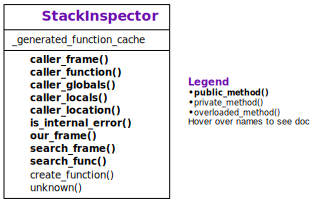

In [18]:
# ignore
display_class_hierarchy([StackInspector],
                        abstract_classes=[
                            StackInspector,
                        ],
                        public_methods=[
                            StackInspector.caller_frame,
                            StackInspector.caller_function,
                            StackInspector.caller_globals,
                            StackInspector.caller_locals,
                            StackInspector.caller_location,
                            StackInspector.search_frame,
                            StackInspector.search_func,
                            StackInspector.is_internal_error,
                            StackInspector.our_frame,
                        ],
                        project='debuggingbook')

## Lessons Learned

* In Python, inspecting objects at runtime is easy.